# BIPI-Net: Physics-Informed Integral Network for Laplace Equation
Please reference to our paper **Physics-Informed Boundary Integral Networks (PIBI-Nets): a Data-Driven Approach for Solving Partial Differential Equations**.

---

## Problem setup

### Laplace equation 
$$ \Delta u(x) := \frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} = 0 $$

$${x}:=(x_1, x_2)\, \in \Omega \subseteq \mathbb{R}^2$$

For sake of simplicity, we choose $\Omega$ to be a circle with radius $r=1.5$ around the origin.

### Single and double layer potential
For a point $x\in\Omega$ inside the domain we have 
$$u(x) = \left( \int_{\partial \Omega} G(x,y)\cdot \frac{\partial g}{\partial n}(y) \; dS_y \right) - \left(\int_{\partial \Omega} \frac{\partial G}{\partial n}(x,y)\cdot g(y) \; dS_y \right).$$
But for a boundary point $x\in\Gamma:=\partial\Omega$ we have get a jump
$$
u(x) = \left( \int_{\partial \Omega} G(x,y)\cdot \frac{\partial g}{\partial n}(y)\; dS_y \right) - \left(\int_{\partial \Omega} \frac{\partial G}{\partial n}(x,y)\cdot g(y)\; dS_y \right) +
\frac{1}{2}g(x).
$$



### Uniformal sampled datapoints based on Dirichlet boundary conditions
Let ${\large\{}u_i(x){\large\}}_{i=0}^{i=N}$ be the measurements constructed by a finite difference solution of the Laplace equation based on Dirichlet boundary conditions.

## Initial settings

In [1]:
# load packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import pandas as pd
import os

In [2]:
# plot specifications
matplotlib.rcParams['text.usetex'] = True
# font properties for axis
font_axis = FontProperties()
font_axis.set_family('serif')
font_axis.set_name('Times New Roman')
font_axis.set_size(115) 
# font properties for 3d plot axis
font_axis_3d = FontProperties()
font_axis_3d.set_family('serif')
font_axis_3d.set_name('Times New Roman')
font_axis_3d.set_size(90)

## Dataset setup

In [3]:
# read data from CSV file
def read_data(csv_file):
    """
    read csv file and store data in x_data, u_data
    
    Args:
    - csv_file
    
    Returns:
    - x_data: tensor of shape (N,2) containing N positions x=(x1,x2)
    - u_data: tensor of shape (N,1) containing u values to corresponding x
    
    """   
    
    # read data from CSV file
    data_pd = pd.read_csv(csv_file)
    data_tensor = torch.tensor(data_pd.values, dtype=torch.float32)  # x1, x2, u
    x_data = data_tensor[:,0:2]
    u_data = data_tensor[:,2].view(-1,1)
    
    return x_data, u_data

x_data, u_data = read_data('dataset_laplace.csv')

## Finite difference solution

In [4]:
# read data from CSV file
x_num = pd.read_csv('X_mesh.csv')
x_num = torch.tensor(x_num.values, dtype=torch.float32) # x1, x2

# read data from CSV file
u_num = pd.read_csv('u_num.csv')
u_num = torch.tensor(u_num.values, dtype=torch.float32) # u

N = u_num.shape
N

torch.Size([10201, 1])

## Collocation and integration points

In [5]:
n_coll_int_points = 1_000
radius = 1.5
middle = torch.tensor((0,0)).view(1,2)

In [6]:
# randomly sample colloction and integration points on the circle
def collocation_integration_points(n, radius, middle):
    # add random shift
    angle = (2 * torch.pi * torch.rand(1)).item()
    
    # define angles
    n = n+1
    theta = np.linspace(0, 2*np.pi, n) + angle
    theta = theta[1::] # to remove one double angle at 0 and 2*pi
    # split theta into two sets
    theta_coll = theta[::2]  # select every second point
    theta_int = theta[1::2] # select every other points
    
    # define collocation points
    x1_coll = middle[:,0] + radius * np.cos(theta_coll).reshape(int(n/2),1)
    x2_coll = middle[:,1] + radius * np.sin(theta_coll).reshape(int(n/2),1)
    x_collocation = np.concatenate((x1_coll,x2_coll), axis=1)
    x_collocation = torch.tensor(x_collocation, dtype=torch.float32).requires_grad_(True)
    
    # define integration points
    x1_int = middle[:,0] + radius * np.cos(theta_int).reshape(int(n/2),1)
    x2_int = middle[:,1] + radius * np.sin(theta_int).reshape(int(n/2),1)
    x_integration = np.concatenate((x1_int,x2_int), axis=1)
    x_integration = torch.tensor(x_integration, dtype=torch.float32).requires_grad_(True)
    
    return x_collocation, x_integration

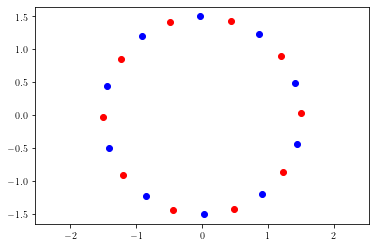

In [7]:
# visualisation of the collocation and integration points
n = 20
x_collocation, x_integration = collocation_integration_points(n, radius, middle)
x_coll_np = x_collocation.detach().numpy()
x_int_np = x_integration.detach().numpy()

# plot collocation and integration points
plt.scatter(x_coll_np[:, 0], x_coll_np[:, 1], color='red', label='Collocation Points')
plt.scatter(x_int_np[:, 0], x_int_np[:, 1], color='blue', label='Integration Points')
plt.axis('equal')
plt.show()

## Physics initialisation

In [8]:
# outer normal directional derivative on boundary of Omega (as a circle)
def outer_normal(x, radius, middle):
    """
    computes outer normal vector normals that is orthogonal to surface of Omega
    
    Args:
    - x: tensor of shape (N,2) containing N positions (x1, x2) on boundary of Omega
    - radius
    - middle
    
    Returns:
    - normals: tensor of shape (N,2) containing the outer normal vector on boundary of Omega at each position in x
    
    """
    
    N = x.shape[0]  # number of points
    xc = x - middle # cetered
    normals = xc / radius

    return normals

In [9]:
# fundamental solution of Laplace equation in 2D
def fundamental_solution(x, y):
    """
    computes the fundamental solution of the Laplace equation in 2D at N positions in  
    two points x and y in R^2, given by
    Phi_0(x, y) = -1/(2π) * log(||x - y||)
    
    Args:
    - x: torch.tensor of position x on Domain Omega, shape (N,2)
    - y: torch.tensor of position y on Domain Omega, shape (N,2) 
    
    Returns:
    - Phi_0: torch.tensor of shape (N,1), value of Laplace fundamental solution over x and y
    
    """
    
    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
  
    Phi_0 = -1/(2*torch.pi) * torch.log(distance)
    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental(x, y):
    """
    computes the gradient *with respect to x* of the Laplace fundamental solution in 2D at N positions x and y, 
    given by ∇y Phi_0(x,y) = - 1/(2π) * (x - y)/||x - y||²
    
    Args:
    - x: torch.tensor of position x on Domain Omega, shape (N,2)
    - y: torch.tensor of position y on Domain Omega, shape (N,2) 
    
    Returns:
    - grad_Phi_0: torch.tensor of shape (N,2), gradient of Laplace fundamental solution over x and y
    
    """
    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)

    grad_Phi_0 = (1/(2*torch.pi)) * ((x - y) / distance**2)
    
    return grad_Phi_0

## Network setup

In [10]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers):
        """
        class implementation of a fully-connected neural network with PyTorch given by Args
        
        Args:
        - N_input: integer, number of input dimension, here N_input = 2 given by x=(x1, x2)
        - N_output: integer, number of output dimession, here N_output = 1 given by u(x)
        - N_hidden: integer, depth of one hidden layer
        - N_layers: integer, number of hidden layers in the network
        
        Methods:
        - forward: forward pass of neural network
        
        """  
        super().__init__()  
        activation = nn.ELU
                
        # input / start layer
        self.fc_start = nn.Sequential(*[ 
                                nn.Linear(N_input, N_hidden),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden),
                                    activation()
                                    ]) 
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output)
        
        
    #------------------------------    
    # forward pass through network
    def forward(self, x):
        """
        forward pass through network building blocks given in this class above
        
        Args:
        - x: tensor of shape (N, 2) containing N positions (x1, x2)

        Returns:
        - u: tensor of shape (N,1) containing the network solution u at position x
        
        """ 
        # forward network
        x = self.fc_start(x)  # input layer
        x = self.fc_hidden(x) # hidden layer(s)
        u = self.fc_end(x)    # output layer 
        
        return u
        
        
    #------------------------------    
    # calculating the potential integrals
    def resample(self):
        # sampling new collocation and integration points
        self.x_coll, self.x_int = collocation_integration_points(n_coll_int_points, radius, middle)
        # calculating the potentials
        self.vmapped_potential_inside = torch.vmap(self.calc_potentials_inside, randomness='same')
        self.vmapped_potential_boundary = torch.vmap(self.calc_potentials_boundary, randomness='same')
        
        
    #------------------------------    
    # calculating the single and double layer potentials for x being an inside Omega point
    def calc_potentials_inside(self, x):
        """
        Inner domain points
        
        """
        y = self.x_int
        normal_y = outer_normal(y, radius, middle)
        g_y = self(y) # boundary density, performs forward pass through  neural network with the input y 
        
        # single_layer
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(g_y)
        dg_dy = torch.autograd.grad(g_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        dg_dn = torch.sum(dg_dy * normal_y, dim=1).view(-1, 1)
        single_layer = torch.mean(G * dg_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = torch.mean(dG_dn * g_y)
        return double_layer.squeeze(), single_layer.squeeze()

    
    #------------------------------
    # calculating the single and double layer potentials for x being a collocation point on the boundary of Omega
    def calc_potentials_boundary(self, x):
        """
        for collocation points on the boundary
        
        """
        y = self.x_int
        g_y = self(y)
        # single_layer
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(g_y)
        dg_dy = torch.autograd.grad(g_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        normal_y = outer_normal(y, radius, middle)
        dg_dn = torch.sum(dg_dy * normal_y, dim=1).view(-1, 1)
        single_layer = torch.mean(G * dg_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = torch.mean(dG_dn * g_y) - 0.5 * pibi(x)
        return double_layer.squeeze(), single_layer.squeeze()
    
    
    #------------------------------
    def predict_u_inside(self, x):
        double_layer, single_layer = self.vmapped_potential_inside(x)
        u_int_data = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_data

    
    #------------------------------
    def predict_u_boundary(self, x):
        double_layer, single_layer = self.vmapped_potential_boundary(x)
        u_int_boundary = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_boundary


In [11]:
def initialise_pibi(lr):

    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 512
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pibi = FCNN(N_input, N_output, N_hidden, N_layers)
    
    # optimizer
    optimiser = torch.optim.Adam(pibi.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5, eps=1e-12, verbose=True)

    # loss function
    mse_loss = torch.nn.MSELoss()
    
    return pibi, optimiser, scheduler, mse_loss

## Train PIBI and visualise trained solution

In [12]:
def train_pibi(iterations, lambda_physics_data, lambda_physics_coll, n, pibi, optimiser, scheduler, mse_loss):
    # n: number of collocation and integration points
    # store loss values
    loss_values = []

    for epoch in range(iterations):
        optimiser.zero_grad()
        
        pibi.resample()
        x_coll = pibi.x_coll

        u_int_data = pibi.predict_u_inside(x_data)
        # compute data loss
        loss_int_data = mse_loss(u_int_data, u_data)

        u_int_coll = pibi.predict_u_boundary(x_coll)
        # compute collocation loss
        loss_int_coll = mse_loss(u_int_coll, torch.zeros_like(u_int_coll))
        
        # backpropagate weighted joint loss, take optimiser step
        loss = lambda_physics_data*loss_int_data + lambda_physics_coll*loss_int_coll
        loss_values.append(loss.item())
        loss.backward()
        optimiser.step()
        scheduler.step(loss)
        
        
        # plot result as training progresses on test set
        if epoch % 2 == 0: 
            print('epoch:', epoch, ', data:', loss_int_data.data, ', coll:', loss_int_coll.data)
            
            if epoch == iterations-1: 
                torch.save(pibi.state_dict(), "pibi_model.pt")
                
                # visualisation of trained solution
                _, x_int = collocation_integration_points(n, radius, middle)
                u_pibi = pibi.predict_u_inside(x_num)
                x1 = (x_num[:, 0]).reshape((101, 101))  
                x2 = (x_num[:, 1]).reshape((101, 101)) 
                u_nn = u_pibi.reshape(x1.shape)  
                u_nn = u_nn.detach()
                
                # evaluation plot in 3D
                fig = plt.figure(figsize=(15,15))
                ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
                surf = ax.plot_surface(x1, x2, u_nn, cmap=cm.jet, zorder=1, alpha=1)
                ax.scatter(x_data[:,0], x_data[:,1], u_data, c='black', marker='o', s=10**2, alpha=1, zorder=2)
                surf.set_clim(vmin=-1, vmax=1) 
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=60, pad=20)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                ax.set_zticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                ax.tick_params(axis='z', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_ylabel('$x_2$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_zlabel('$u$', fontproperties=font_axis_3d, labelpad=55)
                # Save the figure as a JPEG image
                plt.savefig('pibi_3d.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                
                # evaluation plot in 2d
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_nn, cmap='jet', origin='lower', 
                                extent=[torch.min(x1).item(), torch.max(x1).item(), 
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=-1, vmax=1)
                ax.scatter(x_data[:,0], x_data[:,1], c='black', marker='o', s=10**2, alpha=1, zorder=4)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                # Save the figure as a JPEG image 
                plt.savefig('pibi_2d.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                
                # absolute error plot
                u_num_matrix = u_num.reshape(u_nn.shape)
                u_error = torch.abs(u_nn-u_num_matrix)
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_error, cmap='jet_r', origin='lower', 
                                extent=[torch.min(x1).item(), torch.max(x1).item(), 
                                        torch.min(x2).item(), torch.max(x2).item()], 
                                vmin=0, vmax=1.1)
                ax.scatter(x_data[:,0], x_data[:,1], c='black', marker='o', s=10**2, alpha=1, zorder=4)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                plt.savefig('pibi_error.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                u_vec = u_error.reshape(N,1)
                print('min', torch.min(u_vec), 'max', torch.max(u_vec), 'mean', torch.mean(u_vec), 'std', torch.std(u_vec))
            
    return loss_values, pibi

epoch: 0 , data: tensor(0.3018) , coll: tensor(0.0051)
epoch: 2 , data: tensor(0.1015) , coll: tensor(3.3632)
epoch: 4 , data: tensor(0.1169) , coll: tensor(11.0937)
epoch: 6 , data: tensor(0.0826) , coll: tensor(7.0673)
epoch: 8 , data: tensor(0.1021) , coll: tensor(6.5522)
epoch: 10 , data: tensor(0.0796) , coll: tensor(9.4264)
epoch: 12 , data: tensor(0.0887) , coll: tensor(10.7705)
epoch: 14 , data: tensor(0.0766) , coll: tensor(7.7030)
epoch: 16 , data: tensor(0.0803) , coll: tensor(5.0225)
epoch: 18 , data: tensor(0.0798) , coll: tensor(4.9675)
epoch: 20 , data: tensor(0.0730) , coll: tensor(6.8683)
epoch: 22 , data: tensor(0.0748) , coll: tensor(8.8784)
epoch: 24 , data: tensor(0.0727) , coll: tensor(9.0358)
epoch: 26 , data: tensor(0.0704) , coll: tensor(7.9552)
epoch: 28 , data: tensor(0.0708) , coll: tensor(7.3469)
epoch: 30 , data: tensor(0.0680) , coll: tensor(7.8284)
epoch: 32 , data: tensor(0.0668) , coll: tensor(8.8588)
epoch: 34 , data: tensor(0.0663) , coll: tensor(9.1

epoch: 286 , data: tensor(0.0156) , coll: tensor(86.6517)
epoch: 288 , data: tensor(0.0193) , coll: tensor(84.6156)
epoch: 290 , data: tensor(0.0165) , coll: tensor(85.6707)
epoch: 292 , data: tensor(0.0167) , coll: tensor(90.0930)
epoch: 294 , data: tensor(0.0162) , coll: tensor(92.3750)
epoch: 296 , data: tensor(0.0155) , coll: tensor(90.6134)
epoch: 298 , data: tensor(0.0157) , coll: tensor(89.3881)
epoch: 300 , data: tensor(0.0147) , coll: tensor(92.3738)
epoch: 302 , data: tensor(0.0151) , coll: tensor(96.1423)
epoch: 304 , data: tensor(0.0141) , coll: tensor(96.2377)
epoch: 306 , data: tensor(0.0145) , coll: tensor(94.7856)
epoch: 308 , data: tensor(0.0141) , coll: tensor(95.9951)
epoch: 310 , data: tensor(0.0135) , coll: tensor(99.4990)
epoch: 312 , data: tensor(0.0139) , coll: tensor(101.8371)
epoch: 314 , data: tensor(0.0135) , coll: tensor(101.9238)
epoch: 316 , data: tensor(0.0134) , coll: tensor(101.8605)
epoch: 318 , data: tensor(0.0131) , coll: tensor(103.2644)
epoch: 320

Epoch 00565: reducing learning rate of group 0 to 2.5000e-04.
epoch: 564 , data: tensor(0.0149) , coll: tensor(172.1483)
epoch: 566 , data: tensor(0.0071) , coll: tensor(177.2100)
epoch: 568 , data: tensor(0.0093) , coll: tensor(172.7279)
epoch: 570 , data: tensor(0.0100) , coll: tensor(179.4143)
epoch: 572 , data: tensor(0.0085) , coll: tensor(172.6669)
epoch: 574 , data: tensor(0.0064) , coll: tensor(177.5184)
epoch: 576 , data: tensor(0.0055) , coll: tensor(175.4952)
epoch: 578 , data: tensor(0.0060) , coll: tensor(174.5480)
epoch: 580 , data: tensor(0.0067) , coll: tensor(177.8648)
epoch: 582 , data: tensor(0.0067) , coll: tensor(173.9784)
epoch: 584 , data: tensor(0.0060) , coll: tensor(177.3545)
epoch: 586 , data: tensor(0.0055) , coll: tensor(175.8051)
epoch: 588 , data: tensor(0.0055) , coll: tensor(175.8121)
epoch: 590 , data: tensor(0.0057) , coll: tensor(177.6078)
epoch: 592 , data: tensor(0.0058) , coll: tensor(175.6773)
epoch: 594 , data: tensor(0.0057) , coll: tensor(177.

epoch: 840 , data: tensor(0.0032) , coll: tensor(219.1029)
epoch: 842 , data: tensor(0.0032) , coll: tensor(219.4970)
epoch: 844 , data: tensor(0.0031) , coll: tensor(219.8525)
epoch: 846 , data: tensor(0.0031) , coll: tensor(220.2318)
epoch: 848 , data: tensor(0.0031) , coll: tensor(220.5949)
epoch: 850 , data: tensor(0.0031) , coll: tensor(220.9718)
epoch: 852 , data: tensor(0.0031) , coll: tensor(221.3491)
epoch: 854 , data: tensor(0.0031) , coll: tensor(221.7198)
epoch: 856 , data: tensor(0.0031) , coll: tensor(222.0838)
epoch: 858 , data: tensor(0.0030) , coll: tensor(222.4609)
epoch: 860 , data: tensor(0.0030) , coll: tensor(222.8362)
epoch: 862 , data: tensor(0.0030) , coll: tensor(223.2112)
epoch: 864 , data: tensor(0.0030) , coll: tensor(223.5789)
epoch: 866 , data: tensor(0.0030) , coll: tensor(223.9538)
epoch: 868 , data: tensor(0.0030) , coll: tensor(224.3339)
epoch: 870 , data: tensor(0.0029) , coll: tensor(224.7085)
epoch: 872 , data: tensor(0.0029) , coll: tensor(225.092

epoch: 1116 , data: tensor(0.0016) , coll: tensor(270.4826)
epoch: 1118 , data: tensor(0.0016) , coll: tensor(270.9374)
epoch: 1120 , data: tensor(0.0016) , coll: tensor(271.5229)
epoch: 1122 , data: tensor(0.0019) , coll: tensor(272.1120)
epoch: 1124 , data: tensor(0.0026) , coll: tensor(272.9675)
Epoch 01127: reducing learning rate of group 0 to 1.2500e-04.
epoch: 1126 , data: tensor(0.0044) , coll: tensor(274.2186)
epoch: 1128 , data: tensor(0.0015) , coll: tensor(272.2379)
epoch: 1130 , data: tensor(0.0016) , coll: tensor(272.6047)
epoch: 1132 , data: tensor(0.0017) , coll: tensor(272.0464)
epoch: 1134 , data: tensor(0.0018) , coll: tensor(273.3130)
epoch: 1136 , data: tensor(0.0020) , coll: tensor(271.9244)
epoch: 1138 , data: tensor(0.0022) , coll: tensor(273.8523)
Epoch 01140: reducing learning rate of group 0 to 6.2500e-05.
epoch: 1140 , data: tensor(0.0022) , coll: tensor(271.9133)
epoch: 1142 , data: tensor(0.0017) , coll: tensor(273.6797)
epoch: 1144 , data: tensor(0.0016) ,

epoch: 1384 , data: tensor(0.0014) , coll: tensor(277.8448)
epoch: 1386 , data: tensor(0.0014) , coll: tensor(277.8911)
epoch: 1388 , data: tensor(0.0014) , coll: tensor(277.9283)
epoch: 1390 , data: tensor(0.0014) , coll: tensor(277.9656)
epoch: 1392 , data: tensor(0.0014) , coll: tensor(278.0121)
epoch: 1394 , data: tensor(0.0014) , coll: tensor(278.0570)
epoch: 1396 , data: tensor(0.0014) , coll: tensor(278.0945)
epoch: 1398 , data: tensor(0.0014) , coll: tensor(278.1365)
epoch: 1400 , data: tensor(0.0014) , coll: tensor(278.1718)
epoch: 1402 , data: tensor(0.0014) , coll: tensor(278.2192)
epoch: 1404 , data: tensor(0.0014) , coll: tensor(278.2649)
epoch: 1406 , data: tensor(0.0014) , coll: tensor(278.2992)
epoch: 1408 , data: tensor(0.0014) , coll: tensor(278.3354)
epoch: 1410 , data: tensor(0.0014) , coll: tensor(278.3712)
epoch: 1412 , data: tensor(0.0014) , coll: tensor(278.4296)
epoch: 1414 , data: tensor(0.0014) , coll: tensor(278.4806)
epoch: 1416 , data: tensor(0.0014) , col

epoch: 1658 , data: tensor(0.0013) , coll: tensor(283.6956)
epoch: 1660 , data: tensor(0.0013) , coll: tensor(283.7403)
epoch: 1662 , data: tensor(0.0013) , coll: tensor(283.7816)
epoch: 1664 , data: tensor(0.0013) , coll: tensor(283.8273)
epoch: 1666 , data: tensor(0.0013) , coll: tensor(283.8691)
epoch: 1668 , data: tensor(0.0013) , coll: tensor(283.9213)
epoch: 1670 , data: tensor(0.0013) , coll: tensor(283.9650)
epoch: 1672 , data: tensor(0.0013) , coll: tensor(284.0039)
epoch: 1674 , data: tensor(0.0013) , coll: tensor(284.0497)
epoch: 1676 , data: tensor(0.0013) , coll: tensor(284.1034)
epoch: 1678 , data: tensor(0.0013) , coll: tensor(284.1436)
epoch: 1680 , data: tensor(0.0013) , coll: tensor(284.1755)
epoch: 1682 , data: tensor(0.0013) , coll: tensor(284.2251)
epoch: 1684 , data: tensor(0.0013) , coll: tensor(284.2863)
epoch: 1686 , data: tensor(0.0013) , coll: tensor(284.3271)
epoch: 1688 , data: tensor(0.0013) , coll: tensor(284.3536)
epoch: 1690 , data: tensor(0.0013) , col

epoch: 1932 , data: tensor(0.0011) , coll: tensor(289.9209)
epoch: 1934 , data: tensor(0.0011) , coll: tensor(289.9786)
epoch: 1936 , data: tensor(0.0011) , coll: tensor(290.0064)
epoch: 1938 , data: tensor(0.0011) , coll: tensor(290.0540)
epoch: 1940 , data: tensor(0.0011) , coll: tensor(290.1013)
epoch: 1942 , data: tensor(0.0011) , coll: tensor(290.1608)
epoch: 1944 , data: tensor(0.0011) , coll: tensor(290.2014)
epoch: 1946 , data: tensor(0.0011) , coll: tensor(290.2451)
epoch: 1948 , data: tensor(0.0011) , coll: tensor(290.2714)
epoch: 1950 , data: tensor(0.0011) , coll: tensor(290.3315)
epoch: 1952 , data: tensor(0.0011) , coll: tensor(290.4002)
epoch: 1954 , data: tensor(0.0011) , coll: tensor(290.4312)
epoch: 1956 , data: tensor(0.0011) , coll: tensor(290.4716)
epoch: 1958 , data: tensor(0.0011) , coll: tensor(290.5242)
epoch: 1960 , data: tensor(0.0011) , coll: tensor(290.5677)
epoch: 1962 , data: tensor(0.0011) , coll: tensor(290.5934)
epoch: 1964 , data: tensor(0.0011) , col

epoch: 2206 , data: tensor(0.0010) , coll: tensor(296.3513)
epoch: 2208 , data: tensor(0.0010) , coll: tensor(296.3882)
epoch: 2210 , data: tensor(0.0010) , coll: tensor(296.4201)
epoch: 2212 , data: tensor(0.0010) , coll: tensor(296.4873)
epoch: 2214 , data: tensor(0.0010) , coll: tensor(296.5251)
epoch: 2216 , data: tensor(0.0010) , coll: tensor(296.5598)
epoch: 2218 , data: tensor(0.0010) , coll: tensor(296.6293)
epoch: 2220 , data: tensor(0.0010) , coll: tensor(296.6600)
epoch: 2222 , data: tensor(0.0010) , coll: tensor(296.7096)
epoch: 2224 , data: tensor(0.0010) , coll: tensor(296.7747)
epoch: 2226 , data: tensor(0.0010) , coll: tensor(296.8136)
epoch: 2228 , data: tensor(0.0010) , coll: tensor(296.8518)
epoch: 2230 , data: tensor(0.0010) , coll: tensor(296.9017)
epoch: 2232 , data: tensor(0.0010) , coll: tensor(296.9558)
epoch: 2234 , data: tensor(0.0010) , coll: tensor(296.9898)
epoch: 2236 , data: tensor(0.0010) , coll: tensor(297.0507)
epoch: 2238 , data: tensor(0.0010) , col

epoch: 2480 , data: tensor(0.0009) , coll: tensor(302.7103)
epoch: 2482 , data: tensor(0.0009) , coll: tensor(302.7816)
epoch: 2484 , data: tensor(0.0009) , coll: tensor(302.8539)
epoch: 2486 , data: tensor(0.0009) , coll: tensor(302.8444)
epoch: 2488 , data: tensor(0.0009) , coll: tensor(302.9308)
epoch: 2490 , data: tensor(0.0009) , coll: tensor(302.9754)
epoch: 2492 , data: tensor(0.0009) , coll: tensor(302.9861)
epoch: 2494 , data: tensor(0.0009) , coll: tensor(303.0664)
epoch: 2496 , data: tensor(0.0009) , coll: tensor(303.0943)
epoch: 2498 , data: tensor(0.0009) , coll: tensor(303.1504)
epoch: 2500 , data: tensor(0.0009) , coll: tensor(303.1855)
epoch: 2502 , data: tensor(0.0009) , coll: tensor(303.2516)
epoch: 2504 , data: tensor(0.0009) , coll: tensor(303.2790)
epoch: 2506 , data: tensor(0.0009) , coll: tensor(303.3279)
epoch: 2508 , data: tensor(0.0009) , coll: tensor(303.3986)
epoch: 2510 , data: tensor(0.0009) , coll: tensor(303.4116)
epoch: 2512 , data: tensor(0.0009) , col

epoch: 2754 , data: tensor(0.0008) , coll: tensor(308.8718)
epoch: 2756 , data: tensor(0.0008) , coll: tensor(308.9024)
epoch: 2758 , data: tensor(0.0008) , coll: tensor(308.9513)
epoch: 2760 , data: tensor(0.0008) , coll: tensor(309.0187)
epoch: 2762 , data: tensor(0.0008) , coll: tensor(309.0228)
epoch: 2764 , data: tensor(0.0008) , coll: tensor(309.0856)
epoch: 2766 , data: tensor(0.0008) , coll: tensor(309.1333)
epoch: 2768 , data: tensor(0.0008) , coll: tensor(309.1540)
epoch: 2770 , data: tensor(0.0008) , coll: tensor(309.2203)
epoch: 2772 , data: tensor(0.0008) , coll: tensor(309.2477)
epoch: 2774 , data: tensor(0.0008) , coll: tensor(309.3002)
epoch: 2776 , data: tensor(0.0008) , coll: tensor(309.3373)
epoch: 2778 , data: tensor(0.0008) , coll: tensor(309.3715)
epoch: 2780 , data: tensor(0.0008) , coll: tensor(309.4368)
epoch: 2782 , data: tensor(0.0008) , coll: tensor(309.4618)
epoch: 2784 , data: tensor(0.0008) , coll: tensor(309.5096)
epoch: 2786 , data: tensor(0.0008) , col

epoch: 3028 , data: tensor(0.0007) , coll: tensor(314.4947)
epoch: 3030 , data: tensor(0.0007) , coll: tensor(314.5387)
epoch: 3032 , data: tensor(0.0007) , coll: tensor(314.5714)
epoch: 3034 , data: tensor(0.0007) , coll: tensor(314.6151)
epoch: 3036 , data: tensor(0.0007) , coll: tensor(314.6454)
epoch: 3038 , data: tensor(0.0007) , coll: tensor(314.6961)
epoch: 3040 , data: tensor(0.0007) , coll: tensor(314.7307)
epoch: 3042 , data: tensor(0.0007) , coll: tensor(314.7613)
epoch: 3044 , data: tensor(0.0007) , coll: tensor(314.8181)
epoch: 3046 , data: tensor(0.0007) , coll: tensor(314.8436)
epoch: 3048 , data: tensor(0.0007) , coll: tensor(314.8842)
epoch: 3050 , data: tensor(0.0007) , coll: tensor(314.9344)
epoch: 3052 , data: tensor(0.0007) , coll: tensor(314.9586)
epoch: 3054 , data: tensor(0.0007) , coll: tensor(314.9977)
epoch: 3056 , data: tensor(0.0007) , coll: tensor(315.0532)
epoch: 3058 , data: tensor(0.0007) , coll: tensor(315.0775)
epoch: 3060 , data: tensor(0.0007) , col

epoch: 3302 , data: tensor(0.0006) , coll: tensor(319.4053)
epoch: 3304 , data: tensor(0.0006) , coll: tensor(319.4724)
epoch: 3306 , data: tensor(0.0006) , coll: tensor(319.5027)
epoch: 3308 , data: tensor(0.0006) , coll: tensor(319.5086)
epoch: 3310 , data: tensor(0.0006) , coll: tensor(319.5894)
epoch: 3312 , data: tensor(0.0006) , coll: tensor(319.5683)
epoch: 3314 , data: tensor(0.0006) , coll: tensor(319.6579)
epoch: 3316 , data: tensor(0.0006) , coll: tensor(319.6419)
epoch: 3318 , data: tensor(0.0006) , coll: tensor(319.7022)
epoch: 3320 , data: tensor(0.0006) , coll: tensor(319.7057)
epoch: 3322 , data: tensor(0.0006) , coll: tensor(319.7815)
epoch: 3324 , data: tensor(0.0006) , coll: tensor(319.7850)
epoch: 3326 , data: tensor(0.0006) , coll: tensor(319.8169)
epoch: 3328 , data: tensor(0.0006) , coll: tensor(319.8564)
epoch: 3330 , data: tensor(0.0006) , coll: tensor(319.8976)
epoch: 3332 , data: tensor(0.0006) , coll: tensor(319.9012)
epoch: 3334 , data: tensor(0.0006) , col

epoch: 3576 , data: tensor(0.0006) , coll: tensor(323.4957)
epoch: 3578 , data: tensor(0.0006) , coll: tensor(323.5342)
epoch: 3580 , data: tensor(0.0006) , coll: tensor(323.5785)
epoch: 3582 , data: tensor(0.0006) , coll: tensor(323.5681)
epoch: 3584 , data: tensor(0.0005) , coll: tensor(323.6192)
epoch: 3586 , data: tensor(0.0005) , coll: tensor(323.6599)
epoch: 3588 , data: tensor(0.0005) , coll: tensor(323.6406)
epoch: 3590 , data: tensor(0.0005) , coll: tensor(323.7033)
epoch: 3592 , data: tensor(0.0005) , coll: tensor(323.7052)
epoch: 3594 , data: tensor(0.0005) , coll: tensor(323.7563)
epoch: 3596 , data: tensor(0.0005) , coll: tensor(323.7784)
epoch: 3598 , data: tensor(0.0005) , coll: tensor(323.8042)
epoch: 3600 , data: tensor(0.0005) , coll: tensor(323.8189)
epoch: 3602 , data: tensor(0.0005) , coll: tensor(323.8571)
epoch: 3604 , data: tensor(0.0005) , coll: tensor(323.8659)
epoch: 3606 , data: tensor(0.0005) , coll: tensor(323.9299)
epoch: 3608 , data: tensor(0.0005) , col

epoch: 3850 , data: tensor(0.0005) , coll: tensor(326.6317)
epoch: 3852 , data: tensor(0.0005) , coll: tensor(326.6319)
epoch: 3854 , data: tensor(0.0005) , coll: tensor(326.6932)
epoch: 3856 , data: tensor(0.0005) , coll: tensor(326.7174)
epoch: 3858 , data: tensor(0.0005) , coll: tensor(326.7159)
epoch: 3860 , data: tensor(0.0005) , coll: tensor(326.7159)
epoch: 3862 , data: tensor(0.0005) , coll: tensor(326.7943)
epoch: 3864 , data: tensor(0.0005) , coll: tensor(326.7397)
epoch: 3866 , data: tensor(0.0005) , coll: tensor(326.8388)
epoch: 3868 , data: tensor(0.0005) , coll: tensor(326.7609)
epoch: 3870 , data: tensor(0.0005) , coll: tensor(326.8562)
epoch: 3872 , data: tensor(0.0005) , coll: tensor(326.8822)
epoch: 3874 , data: tensor(0.0005) , coll: tensor(326.8491)
epoch: 3876 , data: tensor(0.0005) , coll: tensor(326.9274)
epoch: 3878 , data: tensor(0.0005) , coll: tensor(326.9408)
epoch: 3880 , data: tensor(0.0005) , coll: tensor(326.9317)
epoch: 3882 , data: tensor(0.0005) , col

epoch: 4124 , data: tensor(0.0004) , coll: tensor(328.8075)
epoch: 4126 , data: tensor(0.0004) , coll: tensor(328.8180)
epoch: 4128 , data: tensor(0.0004) , coll: tensor(328.8597)
epoch: 4130 , data: tensor(0.0004) , coll: tensor(328.8254)
epoch: 4132 , data: tensor(0.0004) , coll: tensor(328.8468)
epoch: 4134 , data: tensor(0.0004) , coll: tensor(328.8622)
epoch: 4136 , data: tensor(0.0004) , coll: tensor(328.8752)
epoch: 4138 , data: tensor(0.0004) , coll: tensor(328.9120)
epoch: 4140 , data: tensor(0.0004) , coll: tensor(328.8664)
epoch: 4142 , data: tensor(0.0004) , coll: tensor(328.9389)
epoch: 4144 , data: tensor(0.0004) , coll: tensor(328.9385)
epoch: 4146 , data: tensor(0.0004) , coll: tensor(328.9071)
epoch: 4148 , data: tensor(0.0004) , coll: tensor(329.0119)
epoch: 4150 , data: tensor(0.0004) , coll: tensor(328.9346)
epoch: 4152 , data: tensor(0.0004) , coll: tensor(328.9926)
epoch: 4154 , data: tensor(0.0004) , coll: tensor(329.0021)
epoch: 4156 , data: tensor(0.0004) , col

epoch: 4398 , data: tensor(0.0004) , coll: tensor(330.1735)
epoch: 4400 , data: tensor(0.0004) , coll: tensor(330.0401)
epoch: 4402 , data: tensor(0.0004) , coll: tensor(330.0753)
epoch: 4404 , data: tensor(0.0004) , coll: tensor(330.0749)
epoch: 4406 , data: tensor(0.0004) , coll: tensor(330.0213)
epoch: 4408 , data: tensor(0.0004) , coll: tensor(330.0773)
epoch: 4410 , data: tensor(0.0004) , coll: tensor(330.1850)
epoch: 4412 , data: tensor(0.0004) , coll: tensor(330.1463)
epoch: 4414 , data: tensor(0.0004) , coll: tensor(330.2205)
epoch: 4416 , data: tensor(0.0004) , coll: tensor(330.2117)
epoch: 4418 , data: tensor(0.0004) , coll: tensor(330.1913)
epoch: 4420 , data: tensor(0.0004) , coll: tensor(330.1609)
epoch: 4422 , data: tensor(0.0004) , coll: tensor(330.1336)
epoch: 4424 , data: tensor(0.0004) , coll: tensor(330.1059)
epoch: 4426 , data: tensor(0.0004) , coll: tensor(330.1339)
epoch: 4428 , data: tensor(0.0004) , coll: tensor(330.2382)
epoch: 4430 , data: tensor(0.0004) , col

epoch: 4670 , data: tensor(0.0003) , coll: tensor(330.5237)
epoch: 4672 , data: tensor(0.0003) , coll: tensor(330.4925)
epoch: 4674 , data: tensor(0.0003) , coll: tensor(330.5265)
epoch: 4676 , data: tensor(0.0003) , coll: tensor(330.5181)
epoch: 4678 , data: tensor(0.0003) , coll: tensor(330.5033)
epoch: 4680 , data: tensor(0.0003) , coll: tensor(330.5286)
epoch: 4682 , data: tensor(0.0003) , coll: tensor(330.5272)
epoch: 4684 , data: tensor(0.0003) , coll: tensor(330.5028)
epoch: 4686 , data: tensor(0.0003) , coll: tensor(330.5255)
epoch: 4688 , data: tensor(0.0003) , coll: tensor(330.5027)
epoch: 4690 , data: tensor(0.0003) , coll: tensor(330.5571)
epoch: 4692 , data: tensor(0.0003) , coll: tensor(330.5026)
epoch: 4694 , data: tensor(0.0003) , coll: tensor(330.5404)
epoch: 4696 , data: tensor(0.0003) , coll: tensor(330.5032)
epoch: 4698 , data: tensor(0.0003) , coll: tensor(330.5435)
epoch: 4700 , data: tensor(0.0003) , coll: tensor(330.5453)
epoch: 4702 , data: tensor(0.0003) , col

epoch: 4944 , data: tensor(0.0003) , coll: tensor(330.6410)
epoch: 4946 , data: tensor(0.0003) , coll: tensor(330.6164)
epoch: 4948 , data: tensor(0.0003) , coll: tensor(330.6331)
epoch: 4950 , data: tensor(0.0003) , coll: tensor(330.6224)
epoch: 4952 , data: tensor(0.0003) , coll: tensor(330.6289)
epoch: 4954 , data: tensor(0.0003) , coll: tensor(330.6356)
epoch: 4956 , data: tensor(0.0003) , coll: tensor(330.6265)
epoch: 4958 , data: tensor(0.0003) , coll: tensor(330.6613)
epoch: 4960 , data: tensor(0.0003) , coll: tensor(330.6324)
epoch: 4962 , data: tensor(0.0003) , coll: tensor(330.6434)
epoch: 4964 , data: tensor(0.0003) , coll: tensor(330.6247)
epoch: 4966 , data: tensor(0.0003) , coll: tensor(330.6499)
epoch: 4968 , data: tensor(0.0003) , coll: tensor(330.6174)
epoch: 4970 , data: tensor(0.0003) , coll: tensor(330.6430)
epoch: 4972 , data: tensor(0.0003) , coll: tensor(330.6234)
epoch: 4974 , data: tensor(0.0003) , coll: tensor(330.6591)
epoch: 4976 , data: tensor(0.0003) , col

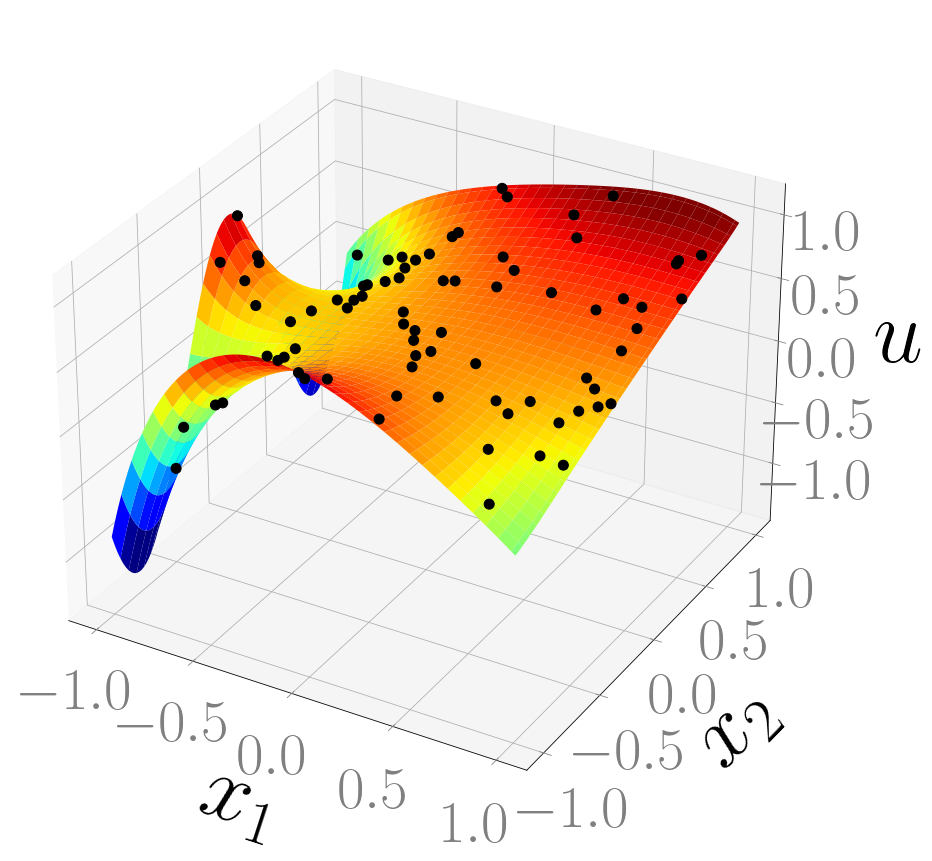

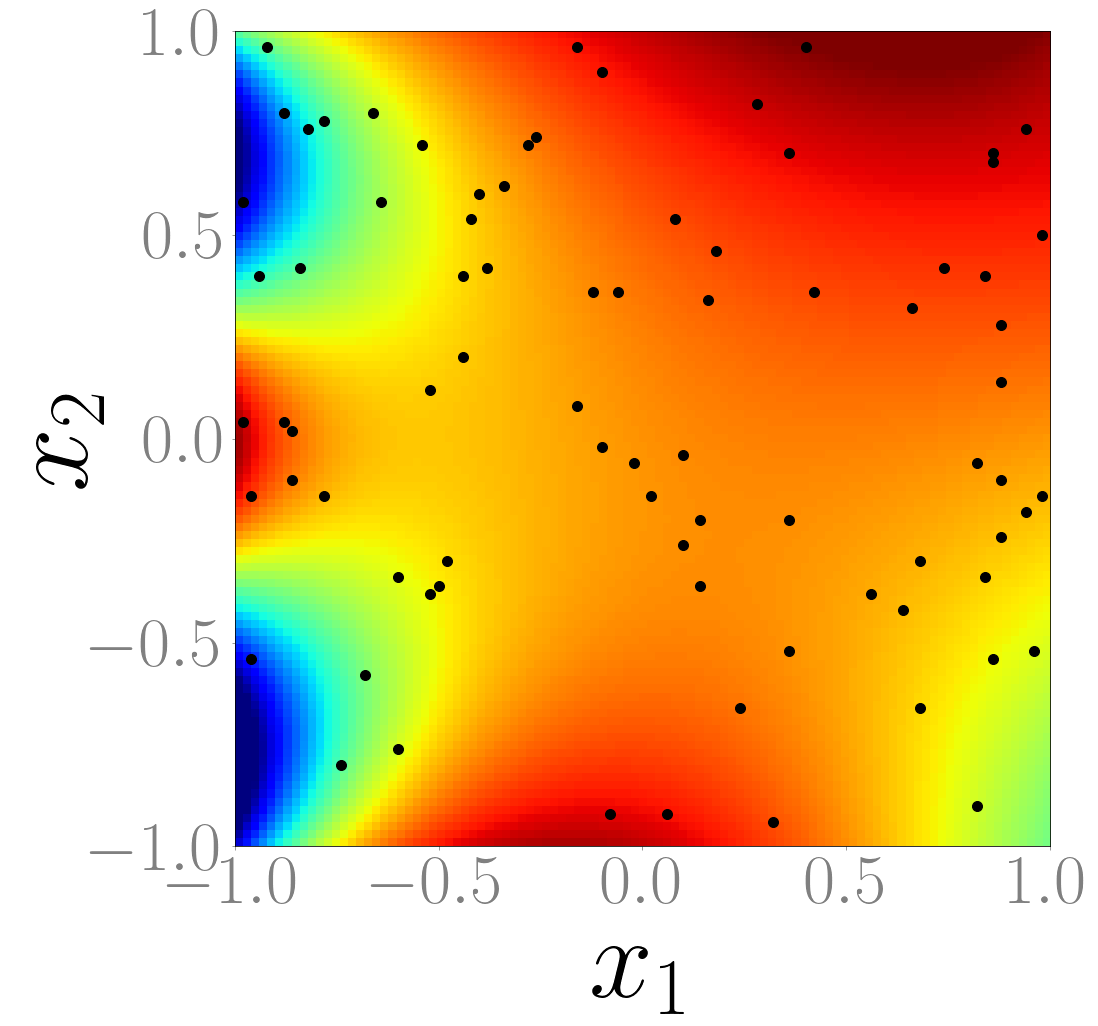

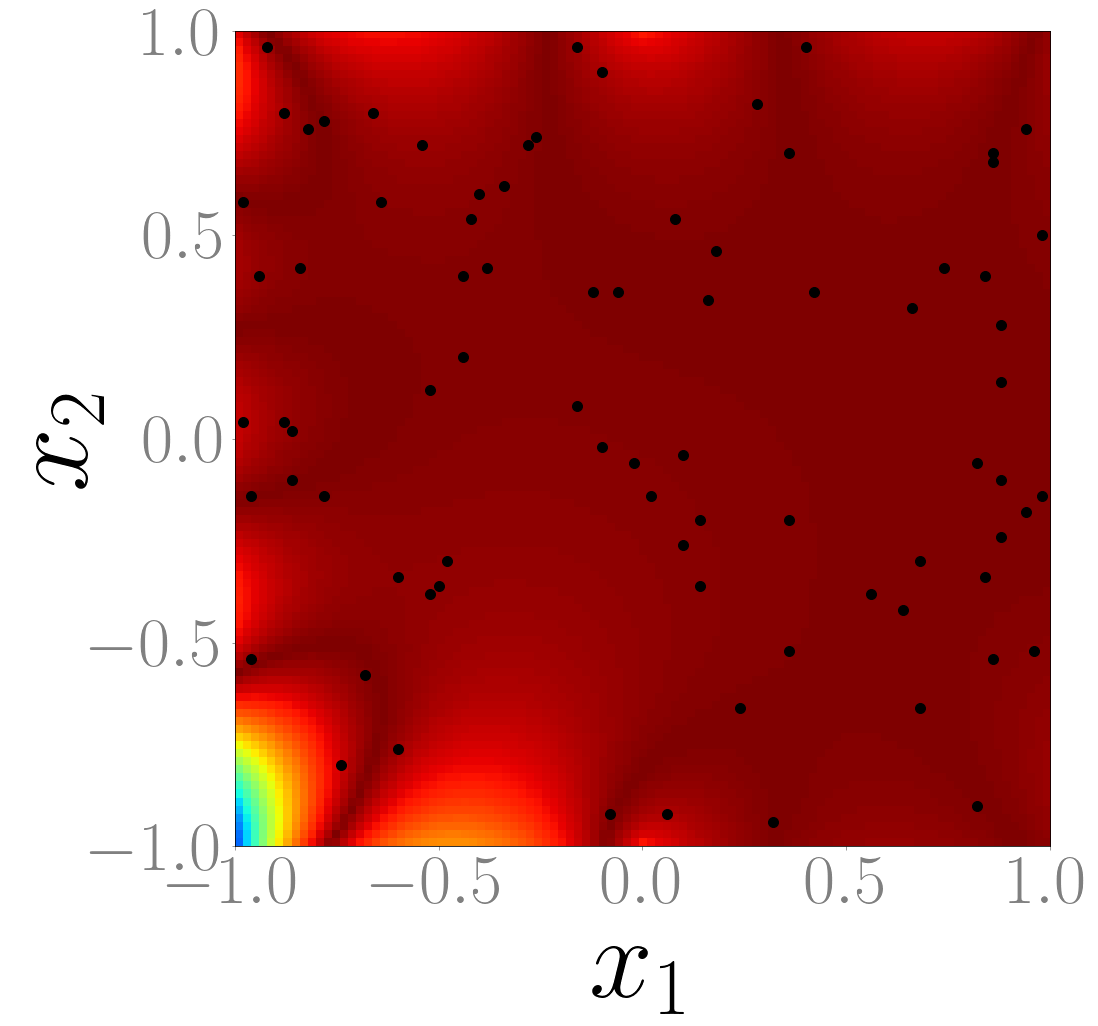

min tensor(1.6689e-06) max tensor(0.8469) mean tensor(0.0241) std tensor(0.0561)


In [13]:
# pibi initialisation
lr = 1e-3 # learning rate
pibi, optimiser, scheduler, mse_loss = initialise_pibi(lr)
    
iterations = 5_001
lambda_physics_data = 1 
lambda_physics_coll = 1e-6 # weighting of collocation loss
loss_values, pibi = train_pibi(iterations, lambda_physics_data, lambda_physics_coll, n, pibi, optimiser, scheduler, mse_loss)

## Visualize convergence of loss function

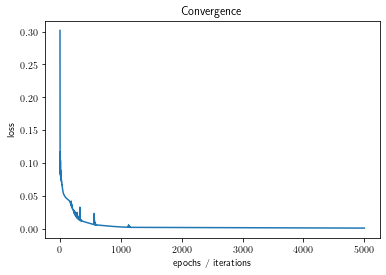

In [14]:
epochs = list(range(1,iterations+1))
fig, ax = plt.subplots()
ax.plot(epochs, loss_values)
ax.set(xlabel='epochs / iterations', 
       ylabel='loss',
       title='Convergence')
#plt.savefig('pibi_loss.jpg', dpi=1000, format='jpeg')
plt.show()